In [17]:
# import sys,os
# sys.path.append(os.path.abspath('../'))
# sys.path.append(os.path.abspath('../modules/'))
# import healpy as h
from flat_sky_codes import tangent_plane_analysis as tpa
# from flat_sky_codes import flat_sky_analysis as fsa
# from masking import gen_masks as gm
# from settings import global_mmf_settings as gset
# from filters import modular_multi_matched_filter as mmf
# from simulate import cluster_templates as cltemp
# from data_preprocess import preprocess_planck_data as ppd
from data_preprocess import get_tangent_planes as gtp
# from astropy.io import fits
# from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr

# %pylab notebook

# def ensure_dir(file_path):
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)
        
        
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_cosmo_cat as ymsr
from modules.settings import global_mmf_settings as gset
from cosmology import cosmo_fn
import multiprocessing as mp
from scipy.optimize import curve_fit
import bces.bces as bces
import time
from astropy.io import fits
from fitstat import fit_Y_M_scaling_law as fit 

%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [12]:
# mmfset.init()
# tmplt=cltemp.cluster_spectro_spatial_templates()
# tmplt.setup_templates()
# mmf_cat=ppd.get_tangent_plane_fnames()
# mmf_cat=ppd.eval_M500_T500_theta500(mmf_cat)

In [18]:
dataset="planck_pr1"
whichch="hfi"
mask_point_sources=False
numprocs=35

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False

figstamp,dir_suffix

('planck_pr1_hfi_inpainted_data', 'hfi_inpainted_data')

In [19]:
outpath="/results/" + dataset + "/planck_cosmo_cat_" + dir_suffix + "/"
tempdatapath="/tempdata/" + dataset + "/planck_cosmo_cat/"
gset.setup_mmf_config(dataset=dataset,outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() 
xsz_cat=pmmf.xsz_cat

In [15]:
emask=gm.return_edge_apodized_mask()
tmplt=cltemp.cluster_spectro_spatial_templates(T_step=1.)
tmplt.setup_templates()
op=mmf.multi_matched_filter(tmplt.sp_ft_bank,tmplt.sz_spec_bank,tmplt.chfiltr,tmplt.fn_yerr_norm)

In [7]:
mmf_cat=ppd.get_tangent_plane_fnames()

In [8]:
idx=0
filename=mmf_cat["FILENAME"][idx]
glat=mmf_cat["GLAT"][idx]
glon=mmf_cat["GLON"][idx]
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
theta500=15.

In [25]:
xsz_cat["FILENAME"][60]

'/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//tempdata/planck_pr1/planck_cosmo_cat/10deg_patches//tangent_planes/cluster_G340.38+60.59.fits'

In [26]:
idx=0
filename=xsz_cat["FILENAME"][60] #"../../tempdata/planck_pr1/planck_cosmo_cat/10deg_patches//tangent_planes/cluster_G106.76-83.24.fits"
f1=fits.open(filename)
glon=float(f1[2].header["GLON"][:-8])
glat=float(f1[2].header["GLAT"][:-8])
projop=tpa.tangent_plane_setup(gset.mmfset.nside,gset.mmfset.xsize,glat,glon,rescale=1.)
theta500=2.

In [29]:
ps_mask=gtp.return_ps_mask(filename)
ext_ps_mask=gtp.return_ext_ps_mask(filename)
data=gtp.return_data(filename)

In [56]:
gtp.gset.mmfset.use_psf_data

True

<IPython.core.display.Javascript object>


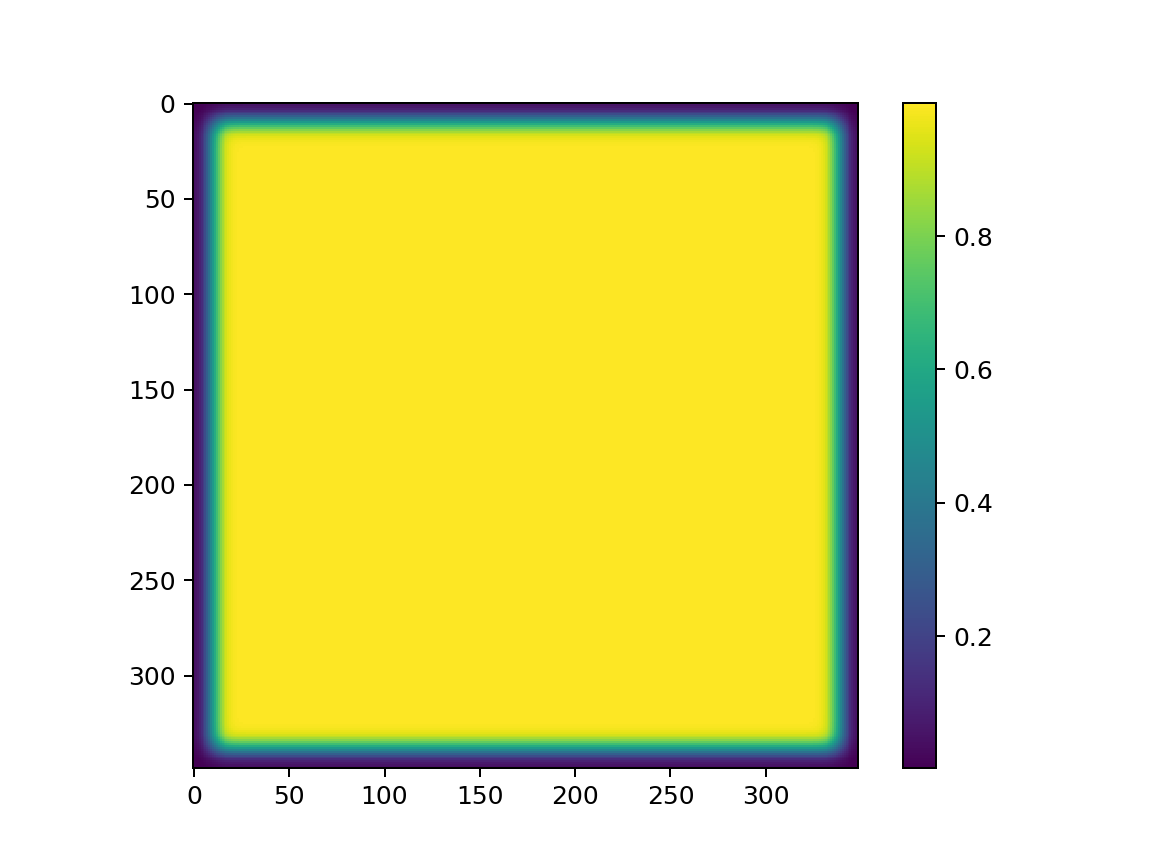

In [47]:
figure()
imshow(emask)
colorbar()

In [48]:
op.get_data_ft(data*emask*ps_mask)
ofdata,oerr,osnr,oyc=op.return_snr(theta500,0.,mask_fdata=False)

In [49]:
data=data - multi_freq_cluster_model
op.get_data_ft(data*emask*ps_mask)
sfdata,serr,ssnr,syc=op.return_snr(theta500,0.,mask_fdata=False)

NameError: name 'multi_freq_cluster_model' is not defined

<IPython.core.display.Javascript object>


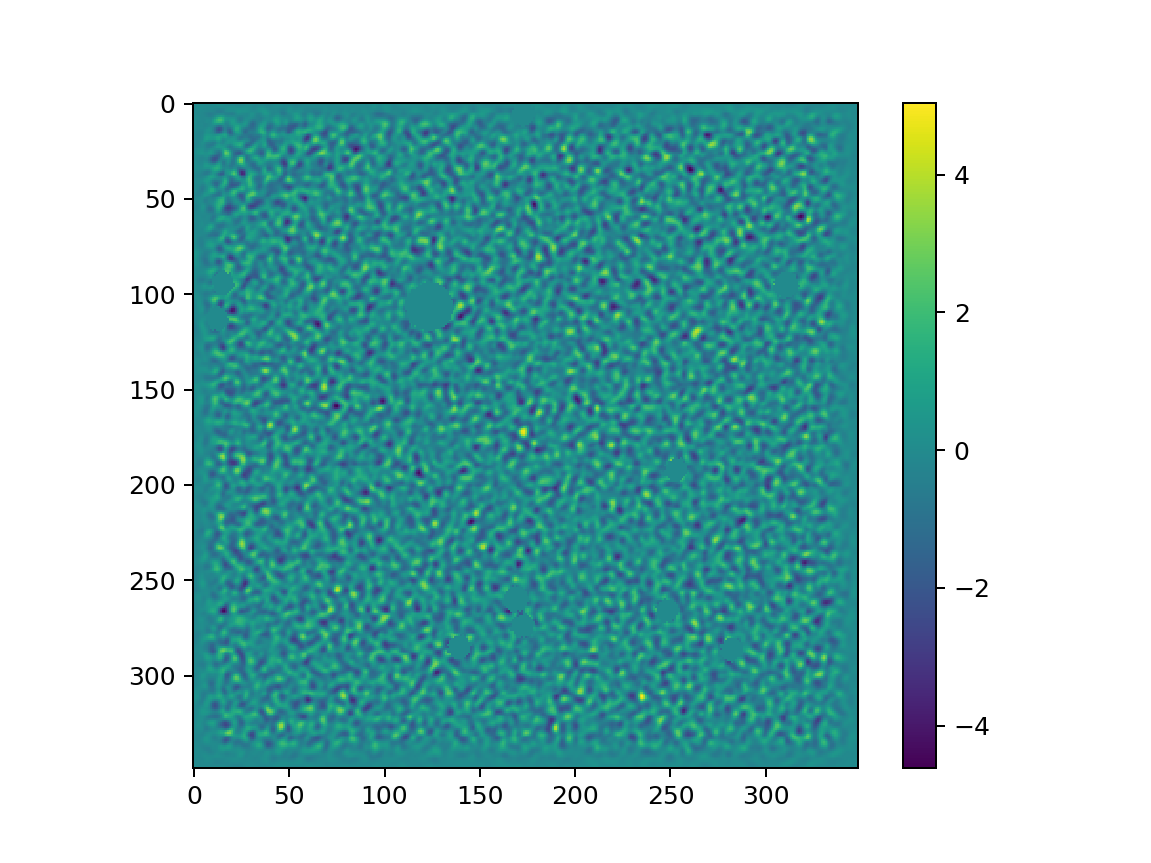

In [51]:
figure()
imshow(ofdata*ext_ps_mask/oerr)
colorbar()

# figure()
# imshow(sfdata*ext_ps_mask/serr)
# colorbar()

# figure()
# imshow(ofdata-sfdata)

# figure()
# plot((ofdata*ps_mask/oerr).ravel())
# plot((sfdata*ps_mask/serr).ravel(),alpha=0.4)
# plot((cluster_model/serr).ravel(),"k-")
# axhline(4)

In [52]:
def return_cluster_catalogue(theta500):
    multi_freq_cluster_model=np.zeros(data.shape,float)
    snrthrmask=np.zeros((mmfset.npix,mmfset.npix),float)
    cluster_model=np.zeros((mmfset.npix,mmfset.npix),float)

    clcnt=-1 ; iteration=-1
    new_cluster_cnt=0 ; old_cluter_cnt=0
    clusdet=[]

    gmask=emask*ext_ps_mask

    while ((iteration<0) or (new_cluster_cnt>old_cluster_cnt)):
        op.get_data_ft((data-multi_freq_cluster_model)*emask*ps_mask)
        fdata,err,snr,yc=op.return_snr(theta500,0.,mask_fdata=False)
        iteration=iteration+1


        old_cluster_cnt=new_cluster_cnt
        snrthrmask[:]=1.
        while(max((fdata*snrthrmask*gmask/err).ravel())>4.):
            clcnt=clcnt+1
            max_snr=max((fdata*snrthrmask*gmask/err).ravel())
            x,y=np.where(fdata*snrthrmask*gmask/err == max_snr)
            glon,glat=projop.ij2ang(x,y)
            nx,ny=projop.ang2ij(glon,glat)
            if clcnt<=1:
                clusdet=np.array([glon,glat,fdata[x,y][0]/err,fdata[x,y][0],theta500])
            else:
                clusdet=np.vstack((clusdet,np.array([glon,glat,fdata[x,y][0]/err,fdata[x,y][0],theta500])))
            cluster_model=cluster_model + sc.gen_field_cluster_template(x,y,theta500,fdata[x,y],mmfset.npix,mmfset.reso)
            snrthrmask=snrthrmask*gen_peak_mask(x,y,max(theta500,15.))
        new_cluster_cnt=clcnt

        #print new_cluster_cnt,old_cluster_cnt

        cluster_model_ft=fsa.map2alm(cluster_model,mmfset.reso)
        for i, ch in enumerate(mmfset.channels):
            multi_freq_cluster_model[i,]=fsa.alm2map(cluster_model_ft*op.chfiltr[ch]*op.sz_spec_bank[0][ch],mmfset.reso)
    return clusdet,err

In [53]:
theta500=np.arange(2,51,1)

In [54]:
start=time.time()
clus_cat={}
ycerr=np.zeros(np.size(theta500),float)
for irdx, rad in enumerate(theta500):
    print rad
    clusdet,err=return_cluster_catalogue(rad)
    clus_cat[rad]=clusdet
    ycerr[irdx]=err
print time.time()-start

2


NameError: global name 'mmfset' is not defined

In [104]:
def return_distance(glon1,glat1,glon2,glat2):
    theta1=(90.-glat1)*np.pi/180.
    theta2=(90.-glat2)*np.pi/180.
    phi1=glon1*np.pi/180.
    phi2=glon2*np.pi/180.
    cosbeta=np.sin(theta1)*np.sin(theta2)*np.cos(phi2-phi1)+np.cos(theta1)*np.cos(theta2)
    beta=np.arccos(cosbeta)*180.*60./np.pi
    return beta

In [122]:
clus_cat[theta500[2]].shape

TypeError: 'float' object has no attribute '__getitem__'

In [121]:
tile_cluscat=clus_cat[theta500[0]][:]
for irdx,rad in enumerate(theta500[1:]):
    clusdet=clus_cat[rad]
    for i in range(clusdet.shape[0]):
        glon1=clusdet[i,0] ; glat1=clusdet[i,1] ; snr_new=clusdet[i,2]
        cluster_matched=False
        for j in range(tile_cluscat.shape[0]):
            glon2=tile_cluscat[j,0] ; glat2=tile_cluscat[j,1] ; snr_old=tile_cluscat[j,2]
            d=return_distance(glon1,glat1,glon2,glat2)            
            if d<10.:
                cluster_matched=True
                if snr_old<snr_new:
#                     print "Updating cluster"
#                     print "Old :",tile_cluscat[j,:],
#                     print "New :",clusdet[i,:]
                    tile_cluscat[j,:]=clusdet[i,:]
        if not cluster_matched:
#             print "found new cluster"
#             print "old catalogue size:",tile_cluscat.shape[0]
             tile_cluscat=np.vstack((tile_cluscat,clusdet[i,:]))
#             print "old catalogue size:",tile_cluscat.shape[0]

TypeError: 'float' object has no attribute '__getitem__'

In [107]:
tile_cluscat.shape

(24, 5)

In [108]:
cluster_model=np.zeros((mmfset.npix,mmfset.npix),float)
multi_freq_cluster_model=np.zeros(data.shape,float)
for i in range(tile_cluscat.shape[0]):
    glon=tile_cluscat[i,0] 
    glat=tile_cluscat[i,1]
    yc=tile_cluscat[i,3]
    theta500=tile_cluscat[i,4]
    x,y=projop.ang2ij(glon,glat)
    cluster_model=cluster_model + sc.gen_field_cluster_template(x,y,theta500,yc,mmfset.npix,mmfset.reso)
    
cluster_model_ft=fsa.map2alm(cluster_model,mmfset.reso)
for i, ch in enumerate(mmfset.channels):
    multi_freq_cluster_model[i,]=fsa.alm2map(cluster_model_ft*op.chfiltr[ch]*op.sz_spec_bank[0][ch],mmfset.reso)

<IPython.core.display.Javascript object>


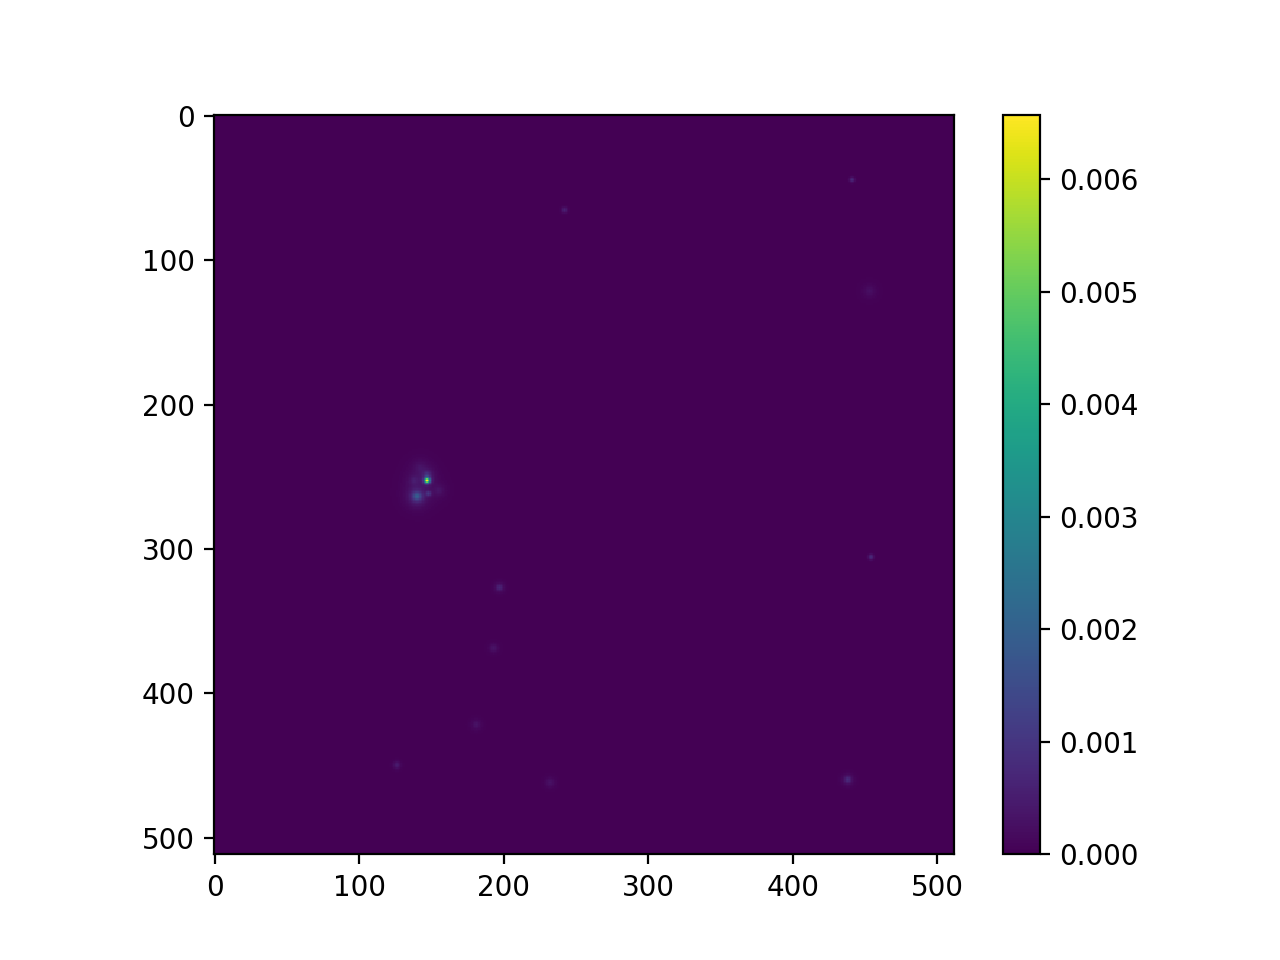

In [110]:
figure()
imshow(multi_freq_cluster_model[5,])
colorbar()

<IPython.core.display.Javascript object>


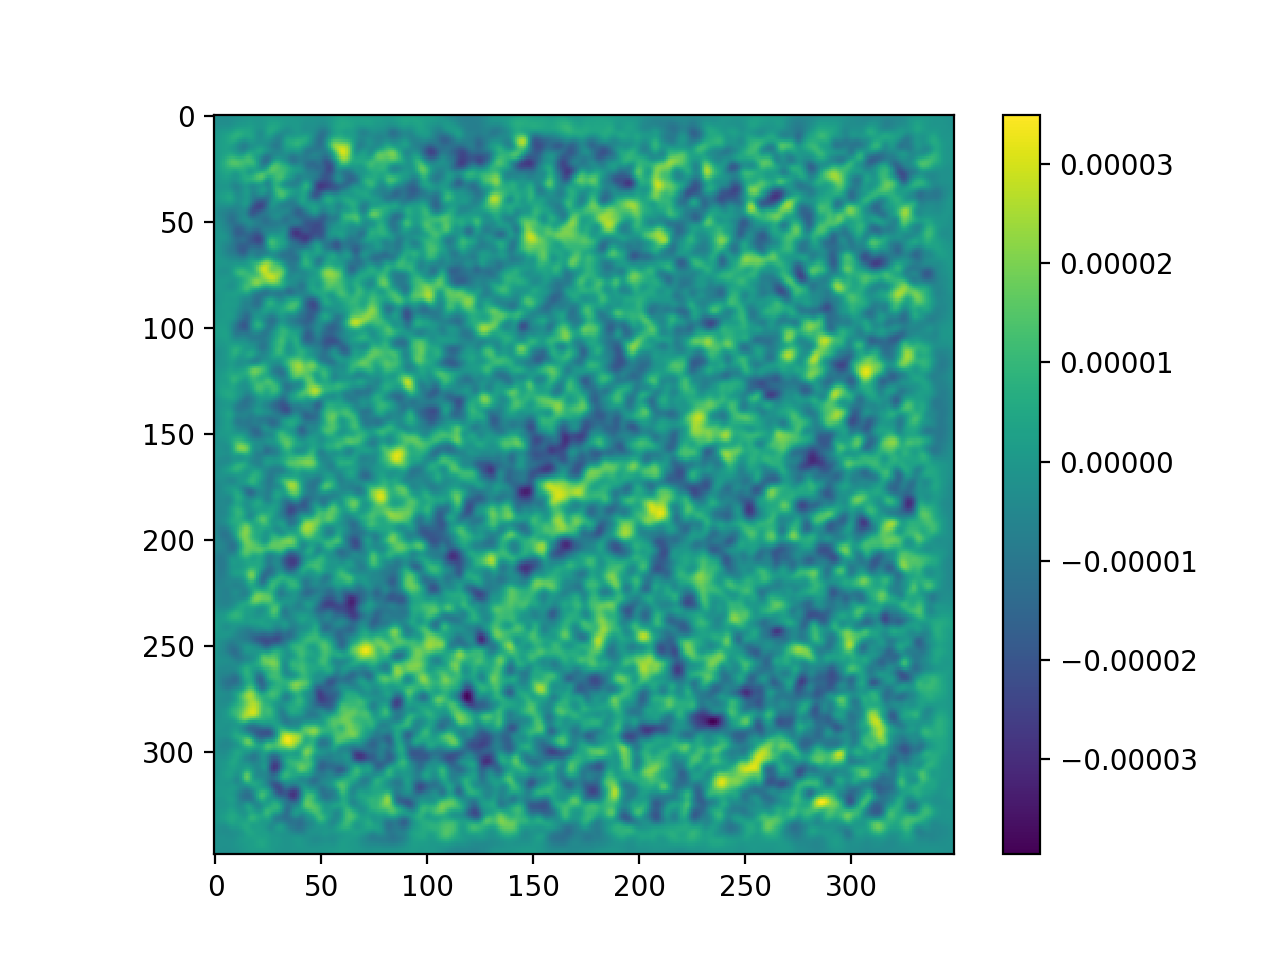

<IPython.core.display.Javascript object>


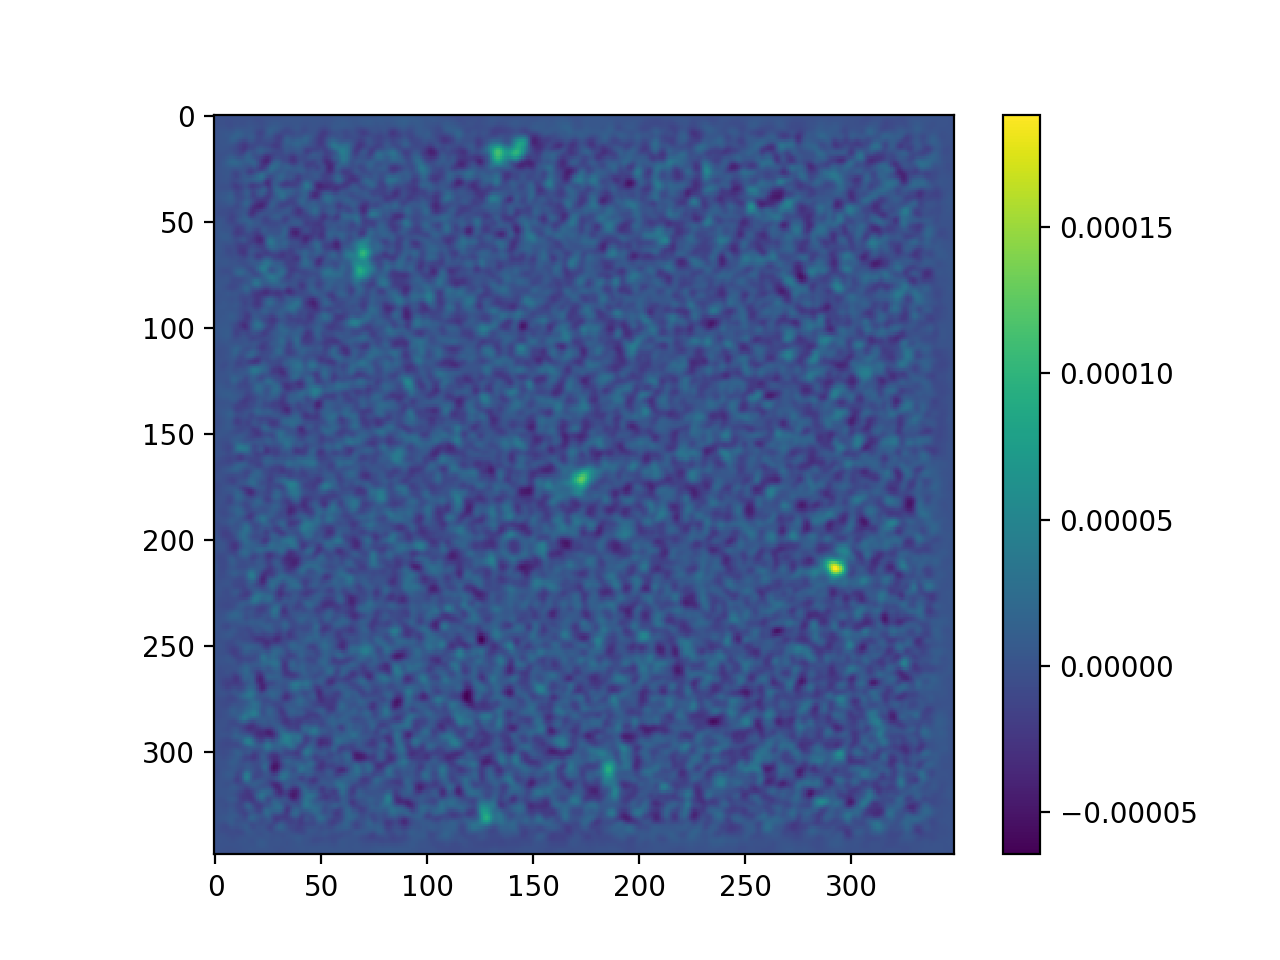

<IPython.core.display.Javascript object>


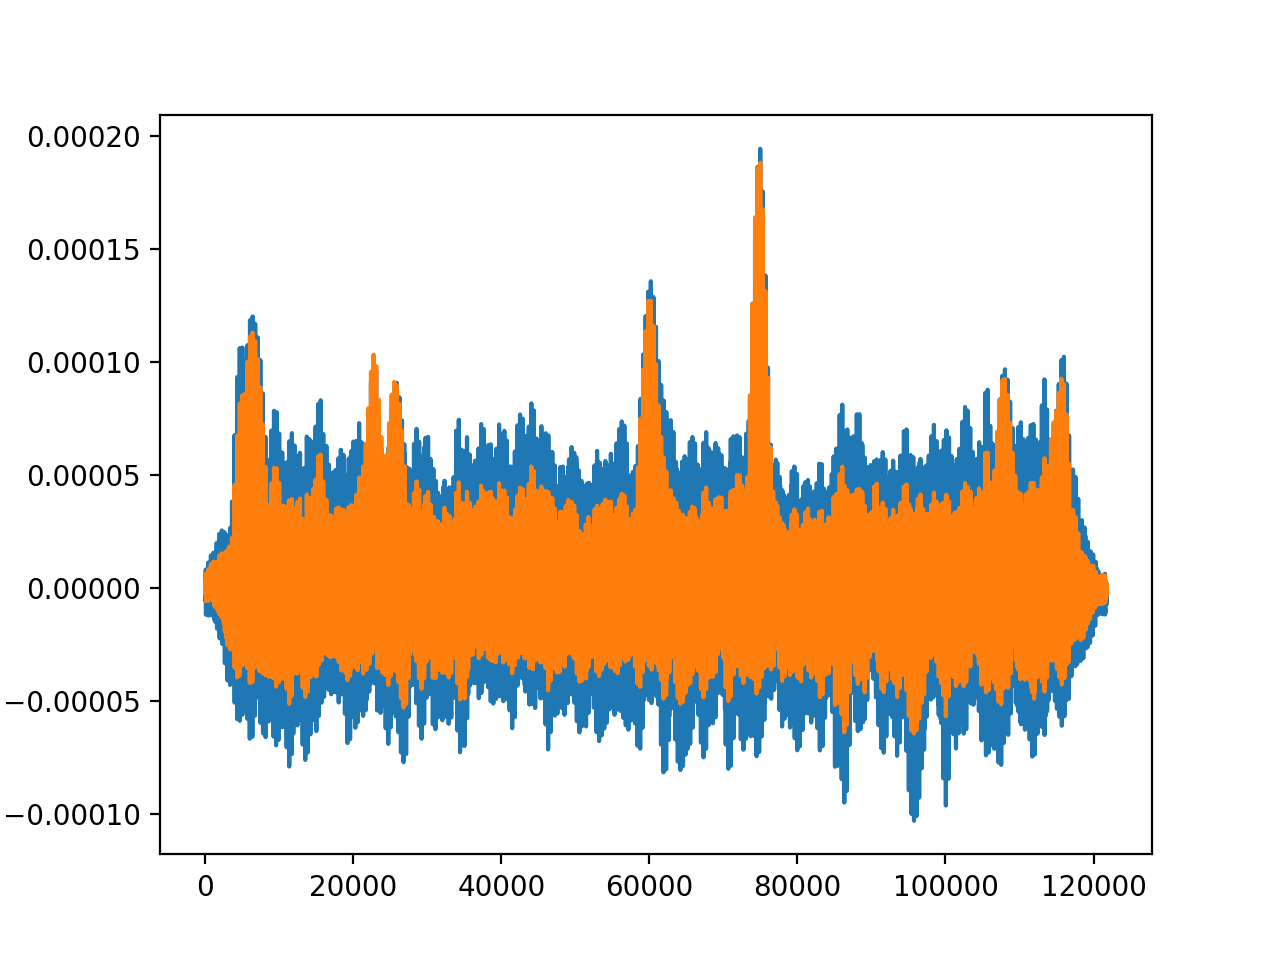

In [279]:
figure()
imshow(fdata)
colorbar()

figure()
imshow(ofdata-fdata)
colorbar()

figure()
plot((ofdata).ravel())
plot((ofdata-fdata).ravel())

In [125]:
import healpy as h

In [182]:
d100=h.read_map("../data/Planck/maps/HFI_SkyMap_353-psb-field-IQU_2048_R3.00_full.fits")

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [183]:
clusdet[0]

[-4.8757557517851025,
 46.174690503865371,
 4.0301155290310571e-05,
 5.0421163019436507e-06,
 0]

In [184]:
glon=clusdet[5][0]
glat=clusdet[5][1]
x,y=projop.ang2ij(glon,glat)
print x,y

331 128


In [185]:
d100[h.ang2pix(2048,glon,glat,lonlat=True)]

0.00066295819124206901

In [186]:
data[6,x,y]

0.00066295819124206901

In [34]:
mmf_cat["FILENAME"]

['/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//data/tangent_planes/planck/10deg_patches/cluster_G000.04+45.13.fits',
 '/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//data/tangent_planes/planck/10deg_patches/cluster_G000.13+78.04.fits',
 '/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//data/tangent_planes/planck/10deg_patches/cluster_G000.40-41.86.fits',
 '/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//data/tangent_planes/planck/10deg_patches/cluster_G000.77-35.69.fits',
 '/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detection/Planck_MMF//data/tangent_planes/planck/10deg_patches/cluster_G002.77-56.16.fits',
 '/Users/adityarotti/Documents/Work/Projects/Relativistic-SZ/MMF-filters-for-rSZ-cluster-detect